In [2]:
import boto3
import io
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

#import awswrangler as wr
#import s3fs
#from fastparquet import write

import joblib

#modeling
import statsmodels.api as sm
from statsmodels.api import add_constant
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,ShuffleSplit, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay,\
classification_report, accuracy_score, f1_score, precision_recall_curve
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
import sklearn.metrics as metrics
from sklearn.metrics import make_scorer, roc_auc_score, log_loss, brier_score_loss
from sklearn.utils import resample


import lightgbm as lgbm

plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings("ignore")

### Load Data

In [3]:
df= pd.read_parquet('complaints_processed_v2.parquet')

### global variable

In [4]:
out_date = '2022-09-01'

### Performance Metrics

In [5]:
#roc curve
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

In [6]:
def fn_importance_features(model):
    clf = model
    feature_importances_data = []
    features = train_X.columns
    for feature_name, feature_importance in zip(features, clf.feature_importances_):
        feature_importances_data.append({
            'feature': feature_name,
            'importance': feature_importance
        })

    # Plot the results
    pd.DataFrame(feature_importances_data)\
        .set_index('feature')\
        .sort_values(by='importance')[-20::]\
        .plot(title='Top 20 most important features: '+ str(type(model).__name__),
              kind='barh',figsize=(10, 6),
              color='#348ABD',alpha=0.6,
              lw='1', edgecolor='#348ABD',grid=False,)

In [7]:
#key performance metrics
def fn_metrics(act, prob, pred):
    #ROC
    fpr, tpr, thresholds = roc_curve(act, prob)
    roc_auc = auc(fpr, tpr)
    plot_roc_curve(fpr, tpr)
    
    print ('ROC value of:{:.2f}'.format(roc_auc*100))
    print ('Accuracy:{:.2f}'.format(accuracy_score(act, pred)*100))
    print ('F1 score:{:.2f}'.format(f1_score(act, pred)*100))
    print ('Recall:{:.2f}'.format(recall_score(act, pred)*100))
    print ('Precision:{:.2f}'.format(precision_score(act, pred)*100))
    print ('\n clasification report:\n',classification_report(act, pred))
     
    #plot confusion matrix    
    fig, ax = plt.subplots(1,1,figsize=(8,6))
    plt.rcParams.update({'font.size': 16})
    ConfusionMatrixDisplay(confusion_matrix(pred, act, labels=[1,0]), 
                       display_labels=['Yes_Complaints','No_Complaints']).plot(values_format=".0f",ax=ax)

    ax.set_xlabel("Actual Label")
    ax.set_ylabel("Predicted Label")
    plt.show()

### Features

In [10]:
features =[
'complaint',
'as_of_dt',
'closed',
'PREM_PAY_DUR',
'PREM_PAY_AGE_NUM',
'CVRG_DUR',
'CVRG_AGE_NUM',
'LVL_PREM_PRD_NUM',
'LVL_PREM_PRD_AGE',
'STATUS',
'PREM_MODE',
#'ISSUE_AGE',
'UNDERWRITING',
'FACE_AMT',
'PUA_AMT',
'LOAN_AMT',
'BASE_CASH',
'PUA_CASH',
'SCHEDULED_PREMIUM',
'prod_type_cd',
'individual_age_num',
'gndr_cd',
'clnt_cd',
'deceased_ind',
'rtl_dstrb_orphn_cd_s',
'subj_act_ind',
'subj_aum_amt',
'line_of_bus_cd',
'istrust',
'prod_grp_cd',
'prod_subgr_cd',
'incrm_embdv_b_rt',
'annlz_prem_amt',
'rtl_dstrb_orphn_cd_h',
'gaap_revn_val_h',
'hhld_aum_amt',
'hhld_act_ind',
'head_hhld_age_num',
'hhld_adlt_cnt',
'hhld_chld_cnt',
'incm_rng_cd',
'length_of_res_cd',
'wc_tot_asset_amt',
'hhld_qdrnt_cd',
'wc_asset_mix_anty_amt',
'wc_asset_mix_bond_amt',
'wc_asset_mix_dep_amt',
'wc_asset_mix_mf_amt',
'wc_asset_mix_oth_asset_amt',
'wc_asset_mix_stk_amt',
'ixi_fin_cohort_cd',
'ixi_wlth_desc',
'dwelling_type_cd',
'ixi_buoyancy',
'tred_serv_tag_cd',
'net_wrth_gold_cd',
'home_own_ind',
'prmr_prsnc_chld_ind',
'prim_occup_cd',
'hold_duration',
'SR_count_lag1',
'closed_lag1',
'num_sr_cat_lag1',
'num_sr_desc_lag1',
'FACE_AMT_mom_change',
'PUA_AMT_mom_change',
'LOAN_AMT_mom_change',
'SCHEDULED_PREMIUM_mom_change',
'subj_aum_amt_mom_change',
'annlz_prem_amt_mom_change',
'age_bucket'
]

In [12]:
ml_dataset =df[features]
ml_dataset.shape

(1025808, 70)

In [13]:
# ml_dataset=ml_dataset.dropna()
# ml_dataset.shape

### Preprocessing: Categorical

In [14]:
%%time
cat_features = [
'STATUS',
'PREM_MODE',
'UNDERWRITING',
'prod_type_cd',
'gndr_cd',
'clnt_cd',
'home_own_ind',
'subj_act_ind',
'deceased_ind',
'rtl_dstrb_orphn_cd_s',
'istrust',
'line_of_bus_cd',
'prod_grp_cd',
'prod_subgr_cd',
'length_of_res_cd',
'incm_rng_cd',
'hhld_act_ind',
'ixi_fin_cohort_cd',
'dwelling_type_cd',
'ixi_buoyancy',
'ixi_wlth_desc',
'net_wrth_gold_cd',
'tred_serv_tag_cd',
'prmr_prsnc_chld_ind',
'prim_occup_cd',
'age_bucket'    
]   

for f in ml_dataset[cat_features]:
    print(f)
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(ml_dataset[f].values))
    ml_dataset[f] = lbl.transform(list(ml_dataset[f].values))

STATUS
PREM_MODE
UNDERWRITING
prod_type_cd
gndr_cd
clnt_cd
home_own_ind
subj_act_ind
deceased_ind
rtl_dstrb_orphn_cd_s
istrust
line_of_bus_cd
prod_grp_cd
prod_subgr_cd
length_of_res_cd
incm_rng_cd
hhld_act_ind
ixi_fin_cohort_cd
dwelling_type_cd
ixi_buoyancy
ixi_wlth_desc
net_wrth_gold_cd
tred_serv_tag_cd
prmr_prsnc_chld_ind
prim_occup_cd
age_bucket
CPU times: total: 9.69 s
Wall time: 9.71 s


### Preprocessing: Numerical 

In [45]:
%%time
num_features = [x for x in ml_dataset.columns if x not in [cat_features, 'complaint', 'as_of_dt']]

for f in ml_dataset[num_features] :
    if ml_dataset[f].dtype in ('float', 'int'):
        _min = ml_dataset[f].min()
        _max = ml_dataset[f].max()
        scale = _max - _min
        shift = _min

        ml_dataset[f] = (ml_dataset[f] - shift).astype(np.float64) / scale

CPU times: total: 3.33 s
Wall time: 3.33 s


### Create a Target

In [15]:
ml_dataset['__target__'] = ml_dataset['complaint']
del ml_dataset['complaint']

# Remove rows for which the target is unknown.
ml_dataset = ml_dataset[~ml_dataset['__target__'].isnull()]

### Split Train/Validation/Test

In [16]:
# Train data < outdate
train = ml_dataset[ml_dataset['as_of_dt'] < out_date]

# split train to train and  test (validation) data
train, valid = train_test_split(train, test_size=0.15, random_state=101)

# test data >= outdate
test = ml_dataset[ml_dataset['as_of_dt'] >= out_date]

train = train.drop(columns=['as_of_dt'])
valid = valid.drop(columns=['as_of_dt'])
test = test.drop(columns=['as_of_dt'])

#train, test = train_test_split(ml_dataset, test_size=0.2, random_state=101)
print ('Train data has %i rows and %i columns' % (train.shape[0], train.shape[1]))
print ('Valiation data has %i rows and %i columns' % (valid.shape[0], valid.shape[1]))
print ('Test data has %i rows and %i columns' % (test.shape[0], test.shape[1]))

Train data has 665669 rows and 69 columns
Valiation data has 117472 rows and 69 columns
Test data has 234782 rows and 69 columns


In [17]:
train_X = train.drop('__target__', axis=1)
valid_X = valid.drop('__target__', axis=1)
test_X = test.drop('__target__', axis=1)

train_Y = np.array(train['__target__'])
valid_Y = np.array(valid['__target__'])
test_Y = np.array(test['__target__'])

### LGBM Model

In [ ]:
%%time
# with validation and early stoppage: ROC is better than recall

import time
import lightgbm as lgb

t = time.time()
folds = 10    #10
param_comb = 10  #2 #5 #10

lgb_clf = lgb.LGBMClassifier(objective = 'binary', boosting_type = 'gbdt',  random_state=101)
#                              early_stopping_rounds =30, 
lgb_parameters  = {
             'learning_rate': sp_randFloat(),
             'n_estimators':sp_randInt(200, 500), 
             'max_depth':sp_randInt(5, 50), 
             'num_leaves': sp_randInt(10, 100), 
             'min_child_samples': sp_randInt(100, 500), 
             'min_child_weight': [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             #'subsample': sp_randFloat(), 
             'subsample_for_bin': [50000, 100000, 200000, 300000, 400000, 500000],
             'colsample_bytree': sp_randFloat(),
             'reg_alpha': [0, 1e-1, 10,  20, 50, 100, 200],
             'reg_lambda': [0, 1e-1, 10, 20, 50, 100, 200],
             'scale_pos_weight': [5, 7, 8, 10, 15, 20, 25,50, 75, 100],
             'min_split_gain': [0.5e-1, 1e-1, 2e-1, 3e-1, 5e-1, 7.5e-1, 1],
             'bagging_fraction': sp_randFloat()
}

#socring parameters 
scoring = { 'AUC': 'roc_auc',  'Log_loss': 'neg_log_loss', 'F1': 'f1','Recall': 'recall', 'Precision': 'precision'} 

# stratified k-fold
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 101)


# Randomized Grid Search
random_search = RandomizedSearchCV(lgb_clf, param_distributions=lgb_parameters, n_iter=param_comb, 
                                     scoring= scoring,  refit='Recall',   #Recall #AUC #Log_Loss #Brier_loss
                                     #n_jobs=-1,
                                     cv=skf.split(train_X, train_Y), verbose=3, random_state=101)


# fit training data and eval data for early stopping (validate with validation data)
random_search.fit(train_X, train_Y, eval_set = [(valid_X, valid_Y)], eval_metric =  'recall',
                                                early_stopping_rounds = 50, verbose=50)
#eval_metric = 'auc', 'recall', ['recall','binary_logloss']

# results
tune_results = random_search.cv_results_

#best parameter setting
print('Best Parameter setting: ',  random_search.best_params_)
    
#best ROC score
print('Best score Training: ', random_search.best_score_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[LightGBM] [Warning] bagging_fraction is set=0.5163986277024462, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5163986277024462
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.00436378
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.00391727
[CV 1/10] END bagging_fraction=0.5163986277024462, colsample_bytree=0.5706675868681398, learning_rate=0.028474226478096942, max_depth=16, min_child_samples=493, min_child_weight=100.0, min_split_gain=0.05, n_estimators=332, num_leaves=73, reg_alpha=0, reg_lambda=100, scale_pos_weight=5, subsample_for_bin=500000; AUC: (test=0.671) F1: (test=0.000) Log_loss: (test=-0.004) Precision: (test=0.000) Recall: (test=0.000) total time=   2.2s
[LightGBM] [Warning] bagging_fraction is set=0.5163986277024462, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5163986277024462
Training until validation s

[LightGBM] [Warning] bagging_fraction is set=0.07568189764121136, subsample=1.0 will be ignored. Current value: bagging_fraction=0.07568189764121136
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.023002
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0152645
[CV 2/10] END bagging_fraction=0.07568189764121136, colsample_bytree=0.8256526081405013, learning_rate=0.02549692083598487, max_depth=13, min_child_samples=471, min_child_weight=100.0, min_split_gain=0.3, n_estimators=259, num_leaves=44, reg_alpha=50, reg_lambda=0, scale_pos_weight=100, subsample_for_bin=300000; AUC: (test=0.739) F1: (test=0.000) Log_loss: (test=-0.015) Precision: (test=0.000) Recall: (test=0.000) total time=   3.0s
[LightGBM] [Warning] bagging_fraction is set=0.07568189764121136, subsample=1.0 will be ignored. Current value: bagging_fraction=0.07568189764121136
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_loglos

[LightGBM] [Warning] bagging_fraction is set=0.2762388284972628, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2762388284972628
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.00683332
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.00683332
[CV 3/10] END bagging_fraction=0.2762388284972628, colsample_bytree=0.6853063287801783, learning_rate=0.5178674741970474, max_depth=5, min_child_samples=205, min_child_weight=10000.0, min_split_gain=0.1, n_estimators=439, num_leaves=18, reg_alpha=200, reg_lambda=50, scale_pos_weight=10, subsample_for_bin=300000; AUC: (test=0.500) F1: (test=0.000) Log_loss: (test=-0.004) Precision: (test=0.000) Recall: (test=0.000) total time=   1.7s
[LightGBM] [Warning] bagging_fraction is set=0.2762388284972628, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2762388284972628
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss

[LightGBM] [Warning] bagging_fraction is set=0.5787895354754169, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5787895354754169
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.00683332
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.00683332
[CV 4/10] END bagging_fraction=0.5787895354754169, colsample_bytree=0.7348190582693819, learning_rate=0.5419617722295935, max_depth=44, min_child_samples=394, min_child_weight=1000.0, min_split_gain=0.1, n_estimators=303, num_leaves=25, reg_alpha=50, reg_lambda=0, scale_pos_weight=15, subsample_for_bin=200000; AUC: (test=0.500) F1: (test=0.000) Log_loss: (test=-0.004) Precision: (test=0.000) Recall: (test=0.000) total time=   1.5s
[LightGBM] [Warning] bagging_fraction is set=0.5787895354754169, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5787895354754169
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 

[LightGBM] [Warning] bagging_fraction is set=0.830277712198797, subsample=1.0 will be ignored. Current value: bagging_fraction=0.830277712198797
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0714555
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.0133748
[CV 5/10] END bagging_fraction=0.830277712198797, colsample_bytree=0.5381614492475574, learning_rate=0.9224693725672236, max_depth=38, min_child_samples=252, min_child_weight=10.0, min_split_gain=0.5, n_estimators=391, num_leaves=29, reg_alpha=10, reg_lambda=20, scale_pos_weight=10, subsample_for_bin=400000; AUC: (test=0.504) F1: (test=0.000) Log_loss: (test=-0.015) Precision: (test=0.000) Recall: (test=0.000) total time=   3.1s
[LightGBM] [Warning] bagging_fraction is set=0.830277712198797, subsample=1.0 will be ignored. Current value: bagging_fraction=0.830277712198797
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.007851

[LightGBM] [Warning] bagging_fraction is set=0.20978107425796333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.20978107425796333
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.00683332
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.00683332
[CV 6/10] END bagging_fraction=0.20978107425796333, colsample_bytree=0.00928947852083395, learning_rate=0.4404491967531682, max_depth=31, min_child_samples=443, min_child_weight=1000.0, min_split_gain=1, n_estimators=429, num_leaves=96, reg_alpha=0.1, reg_lambda=100, scale_pos_weight=8, subsample_for_bin=200000; AUC: (test=0.500) F1: (test=0.000) Log_loss: (test=-0.004) Precision: (test=0.000) Recall: (test=0.000) total time=   1.8s
[LightGBM] [Warning] bagging_fraction is set=0.20978107425796333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.20978107425796333
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_log

[LightGBM] [Warning] bagging_fraction is set=0.5001167138007933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5001167138007933
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.00719293
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.00413447
[CV 7/10] END bagging_fraction=0.5001167138007933, colsample_bytree=0.138009568258896, learning_rate=0.05280840108926621, max_depth=35, min_child_samples=128, min_child_weight=1, min_split_gain=0.3, n_estimators=214, num_leaves=79, reg_alpha=0.1, reg_lambda=50, scale_pos_weight=20, subsample_for_bin=50000; AUC: (test=0.617) F1: (test=0.000) Log_loss: (test=-0.005) Precision: (test=0.000) Recall: (test=0.000) total time=   3.3s
[LightGBM] [Warning] bagging_fraction is set=0.5001167138007933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5001167138007933
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.00

### export model

In [64]:
#Export to local
joblib.dump(random_search.best_estimator_, 'lgb_model_1.pkl')

#load pickle local python
clf_tuned_lgb =joblib.load('lgb_model_1.pkl')

### Model Fits

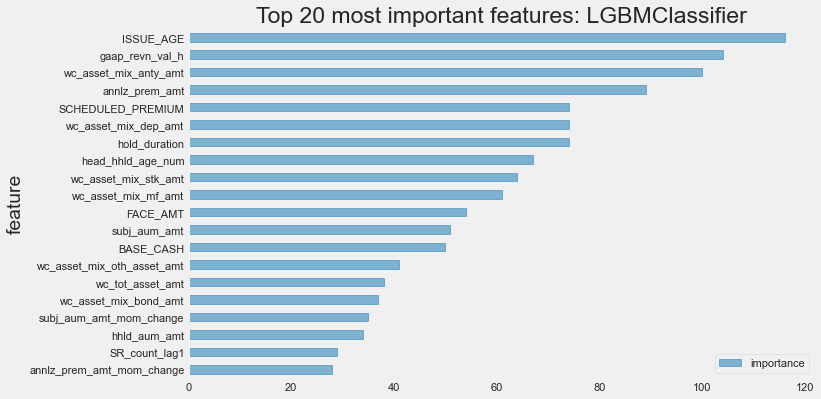

In [101]:
fn_importance_features(clf_tuned_lgb)

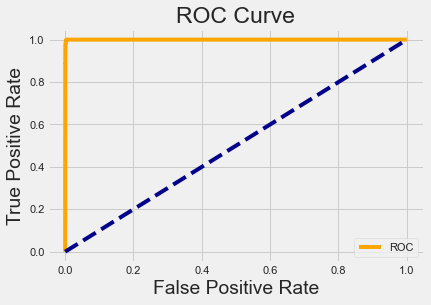

ROC value of:99.98
Accuracy:99.96
F1 score:68.49
Recall:80.41
Precision:59.65

 clasification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    665327
           1       0.60      0.80      0.68       342

    accuracy                           1.00    665669
   macro avg       0.80      0.90      0.84    665669
weighted avg       1.00      1.00      1.00    665669



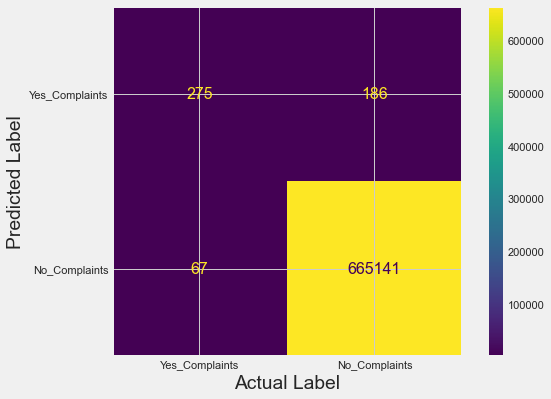

In [66]:
#### In-sample metrics
pred_Y_in = clf_tuned_lgb.predict(train_X)
pred_Y_prob_in = clf_tuned_lgb.predict_proba(train_X)[:,1]
tuned_lgb_prob_in = [train_Y, pred_Y_prob_in]
fn_metrics(train_Y, pred_Y_prob_in, pred_Y_in)

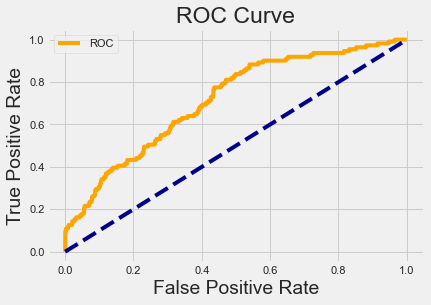

ROC value of:71.42
Accuracy:99.94
F1 score:10.32
Recall:7.21
Precision:18.18

 clasification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    234671
           1       0.18      0.07      0.10       111

    accuracy                           1.00    234782
   macro avg       0.59      0.54      0.55    234782
weighted avg       1.00      1.00      1.00    234782



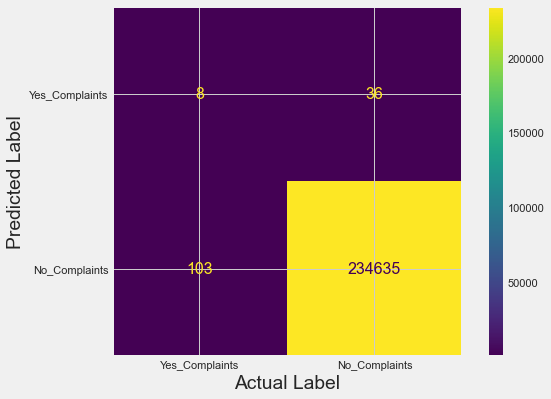

In [67]:
#Out-of-sample metrics 
pred_Y_out = clf_tuned_lgb.predict(test_X)
pred_Y_prob_out = clf_tuned_lgb.predict_proba(test_X)[:,1]
tuned_lgb_prob_out = [test_Y, pred_Y_prob_out]

#print out ROC curve, metrics, and confuction matrix
fn_metrics(test_Y, pred_Y_prob_out, pred_Y_out)

### In-sample Results

In [70]:
## in-sample results 
df_in_predict = pd.DataFrame({'prob': pred_Y_prob_in, 'predict': pred_Y_in}, columns=['prob', 'predict'], index = train_X.index.copy())

# Build scored dataset
results_in = df.join(df_in_predict, how='right')

### Out-of-Sample Results

In [68]:
## out-of-sample results 
df_out_predict = pd.DataFrame({'prob': pred_Y_prob_out, 'predict': pred_Y_out}, columns=['prob', 'predict'], index = test_X.index.copy())

# Build scored dataset
results_out = df.join(df_out_predict, how='left')
#results_out = results_out.sort_index()

In [69]:
df_out = results_out[results_out['as_of_dt'] >= out_date]

In [71]:
df_out.head(5)

,POLICY_NBR,as_of_dt,complaint,closed,PREM_PAY_DUR,PREM_PAY_AGE_NUM,CVRG_DUR,CVRG_AGE_NUM,LVL_PREM_PRD_NUM,LVL_PREM_PRD_AGE,STATUS,PREM_MODE,ISSUE_AGE,UNDERWRITING,FACE_AMT,PUA_AMT,LOAN_AMT,BASE_CASH,PUA_CASH,SCHEDULED_PREMIUM,prod_type_cd,individual_age_num,gndr_cd,clnt_cd,deceased_ind,rtl_dstrb_orphn_cd_s,subj_act_ind,subj_aum_amt,line_of_bus_cd,istrust,prod_grp_cd,prod_subgr_cd,incrm_embdv_b_rt,annlz_prem_amt,rtl_dstrb_orphn_cd_h,gaap_revn_val_h,hhld_aum_amt,hhld_act_ind,head_hhld_age_num,hhld_adlt_cnt,hhld_chld_cnt,incm_rng_cd,length_of_res_cd,wc_tot_asset_amt,hhld_qdrnt_cd,wc_asset_mix_anty_amt,wc_asset_mix_bond_amt,wc_asset_mix_dep_amt,wc_asset_mix_mf_amt,wc_asset_mix_oth_asset_amt,wc_asset_mix_stk_amt,ixi_fin_cohort_cd,ixi_wlth_desc,dwelling_type_cd,ixi_buoyancy,tred_serv_tag_cd,net_wrth_gold_cd,home_own_ind,prmr_prsnc_chld_ind,prim_occup_cd,hold_duration,SR_Count,SR_count_lag1,num_closed,closed_lag1,num_sr_cat,num_sr_cat_lag1,num_sr_desc,num_sr_desc_lag1,FACE_AMT_mom_change,PUA_AMT_mom_change,LOAN_AMT_mom_change,SCHEDULED_PREMIUM_mom_change,subj_aum_amt_mom_change,annlz_prem_amt_mom_change,age_bucket,prob,predict
21,054013772,2022-09-30,0,1,999.0,999.0,999.0,999.0,999.0,999.0,Fully Paid Up,Annual,2.0,None,500.0,14361.0,0.0,500.0,14361.0,0.0,1.0,102.0,U,1.0,1.0,2.0,1.0,0.0,7.0,0.0,L,W,0.0,0.0,2.0,9.10,0.00,1.0,58.0,4,0,4.0,15.0,792985.0,6.0,33176.0,7905.0,207834.0,345845.0,11567.0,186658.0,H30,Mass Affluent,S,6.0,3.0,9,O,Y,None,100.0,2.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.2,>90,0.000069,0.0
22,054013772,2022-09-30,0,1,999.0,999.0,999.0,999.0,999.0,999.0,Fully Paid Up,Annual,2.0,None,500.0,14361.0,0.0,500.0,14361.0,0.0,4.0,102.0,U,1.0,1.0,2.0,1.0,0.0,7.0,0.0,L,W,0.0,5.2,2.0,9.10,0.00,1.0,58.0,4,0,4.0,15.0,792985.0,6.0,33176.0,7905.0,207834.0,345845.0,11567.0,186658.0,H30,Mass Affluent,S,6.0,3.0,9,O,Y,None,100.0,2.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.2,>90,0.000039,0.0
39,055631176,2022-09-30,0,1,999.0,999.0,999.0,999.0,999.0,999.0,Fully Paid Up,Annual,2.0,None,500.0,14361.0,0.0,500.0,14361.0,0.0,1.0,100.0,F,1.0,1.0,2.0,1.0,0.0,7.0,0.0,L,W,0.0,0.0,2.0,102.55,18481.28,1.0,64.0,1,0,8.0,15.0,1297487.0,2.0,41325.0,20421.0,324630.0,582701.0,18948.0,309462.0,L41,Affluent,S,11.0,2.0,9,O,N,4,98.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,>90,0.000218,0.0
42,055673542,2022-09-30,0,1,999.0,999.0,999.0,999.0,999.0,999.0,Fully Paid Up,Annual,2.0,None,500.0,14361.0,0.0,500.0,14361.0,0.0,1.0,101.0,U,1.0,1.0,2.0,1.0,0.0,7.0,0.0,L,W,0.0,0.0,2.0,4.55,0.00,1.0,99.0,2,0,2.0,0.0,1651177.0,3.0,64448.0,24025.0,535855.0,627375.0,19634.0,379840.0,L40,Affluent,S,12.0,3.0,2,None,None,7,99.0,2.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,>90,0.001407,0.0
46,055805543,2022-09-30,0,1,999.0,999.0,999.0,999.0,999.0,999.0,Fully Paid Up,Annual,2.0,None,500.0,14361.0,0.0,500.0,14361.0,0.0,1.0,100.0,U,1.0,1.0,2.0,1.0,0.0,7.0,0.0,L,W,0.0,0.0,2.0,9.10,0.00,1.0,99.0,1,0,1.0,5.0,2886283.0,3.0,44267.0,92162.0,365205.0,1235341.0,26906.0,1122402.0,O53,Affluent,S,12.0,3.0,8,O,None,8,98.0,6.0,2.0,6.0,2.0,2.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,>90,0.001253,0.0


### Shapely Plots

In [76]:
!pip install shap --q

In [82]:
import shap

# select 10000 data points randomly (for computation speed up)
ran_df = test_X.sample(10000)

# Fits the explainer
explainer = shap.Explainer(clf_tuned_lgb.predict, ran_df)
# Calculates the SHAP values 
shap_values = explainer(ran_df)

Permutation explainer: 10001it [11:33, 14.22it/s]                                                                      


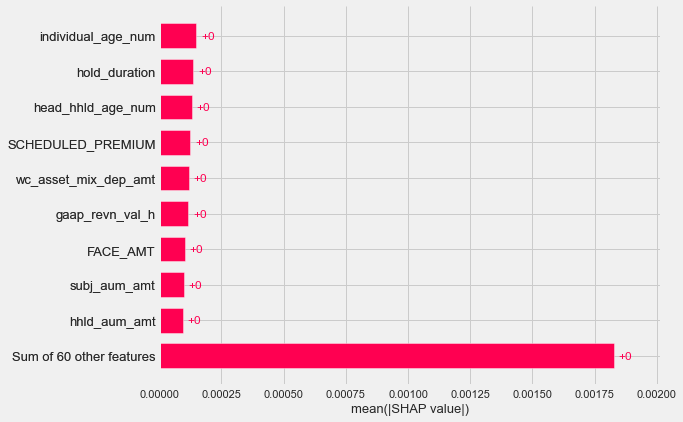

In [84]:
shap.plots.bar(shap_values)

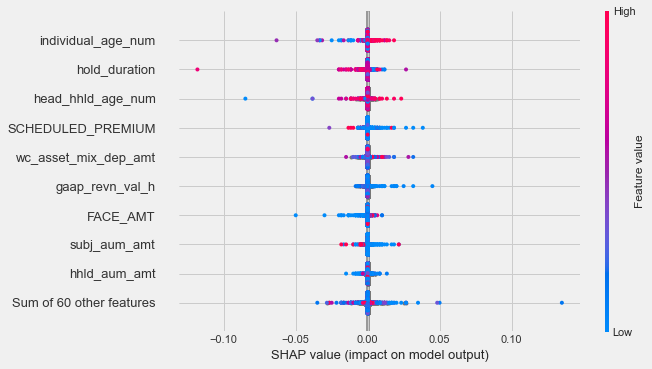

In [85]:
shap.plots.beeswarm(shap_values)

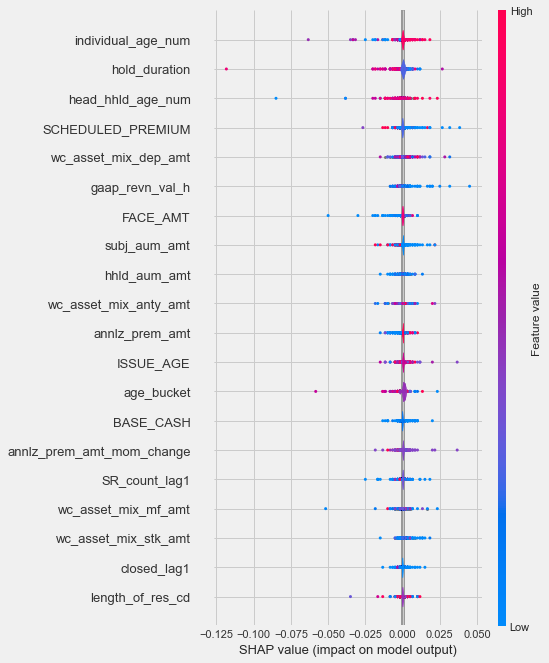

In [86]:
shap.summary_plot(shap_values, plot_type='violin')

### Further analysis of prediction

Text(0.5, 1.0, 'Scatterplot: Age bucket vs. Predicted Probability')

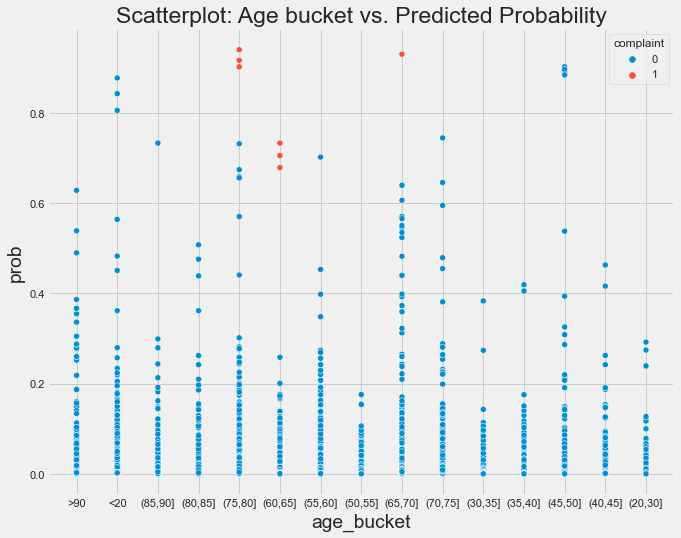

In [109]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(data=df_out, x='age_bucket', y='prob', hue='complaint')
plt.title('Scatterplot: Age bucket vs. Predicted Probability')

Text(0.5, 1.0, 'Scatterplot: Change in Premium vs. Predicted Probability')

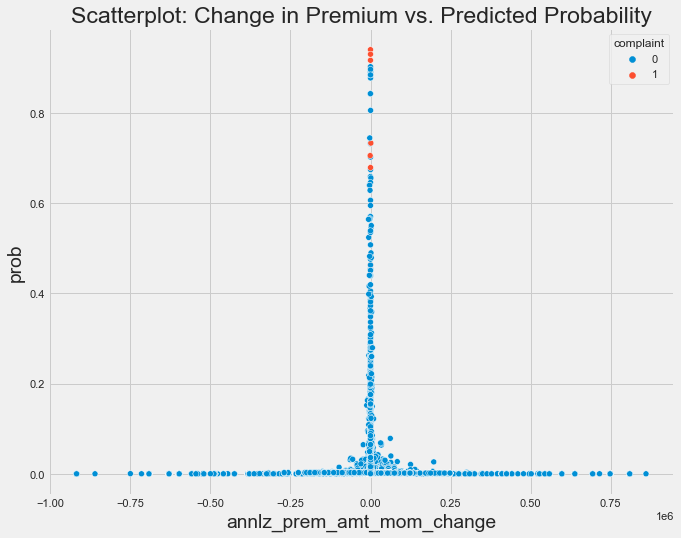

In [108]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(data=df_out, x='annlz_prem_amt_mom_change', y='prob', hue='complaint')
plt.title('Scatterplot: Change in Premium vs. Predicted Probability')